# Cyber URL deception using Computational linguistics , Deep Learning and High-performance web framework

In [3]:
import pandas as pd

def main():

    blacklist = 'phishing_database.csv'
    whitelist = 'whitelist.txt'

    urls = {}
    
    blacklist = pd.read_csv(blacklist)

    #Assign 0 for non-malicious and 1 as malicious for supervised learning.
    for url in blacklist['url']:
        urls[url] = 1
    
    with open(whitelist, 'r') as f:
        lines = f.read().splitlines()
        for url in lines:
            urls[url] = 0

    return urls

In [4]:
from __future__ import print_function
import keras
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.models import load_model
from keras.models import Sequential
from keras.layers import LSTM, GRU, Embedding, Dense
from keras.layers import Dense, Dropout, Activation
from tensorflow.keras.layers import BatchNormalization
import numpy as np

# Get and process URL data and labels.
urls = main()

samples = []
labels = []
for k, v in urls.items():
    samples.append(k)
    labels.append(v)
    #print(k, v)
    
print(labels.count(1))
print(labels.count(0))

29769
38228


In [5]:
# Preprocess data for training.
max_chars = 20000
maxlen = 128

tokenizer = Tokenizer(num_words=max_chars, char_level=True)
tokenizer.fit_on_texts(samples)
sequences = tokenizer.texts_to_sequences(samples)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=maxlen)

labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

# Divide data between training, cross-validation, and test data.
training_samples = int(len(samples) * 0.95)
validation_samples = int(len(labels) * 0.05)
print(training_samples, validation_samples)

indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
'''
x = data
y = labels
'''
x = data[:training_samples]
y = labels[:training_samples]
x_test = data[training_samples: training_samples + validation_samples]
y_test = labels[training_samples: training_samples + validation_samples]


num_chars = len(tokenizer.word_index)+1

embedding_vector_length = 128

Found 69 unique tokens.
Shape of data tensor: (67997, 128)
Shape of label tensor: (67997,)
64597 3399


In [6]:
# Create model for training.
model = Sequential()
model.add(Embedding(num_chars, embedding_vector_length, input_length=maxlen))

model.add(LSTM(units=256, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=256, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=128, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=96))
model.add(Dropout(0.2))
model.add(Dense(units=1))


model.summary()

model.compile(optimizer='adam',
            loss='mean_squared_error',
            metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 128, 128)          8960      
                                                                 
 lstm (LSTM)                 (None, 128, 256)          394240    
                                                                 
 dropout (Dropout)           (None, 128, 256)          0         
                                                                 
 lstm_1 (LSTM)               (None, 128, 256)          525312    
                                                                 
 dropout_1 (Dropout)         (None, 128, 256)          0         
                                                                 
 lstm_2 (LSTM)               (None, 128, 128)          197120    
                                                                 
 dropout_2 (Dropout)         (None, 128, 128)          0

In [7]:
# Train.
model.fit(x, y,
        epochs=1,
        batch_size=20
        )

model.save('prediction_url')

3230/3230 [==============================] - 3514s 1s/step - loss: 0.0772 - accuracy: 0.9013
INFO:tensorflow:Assets written to: prediction_url\assets


INFO:tensorflow:Assets written to: prediction_url\assets


In [8]:
# Evaluate model on test data.
score, acc = model.evaluate(x_test, y_test, verbose=1, batch_size=1024)

print("Model Accuracy: {:0.2f}%".format(acc * 100))

4/4 [==============================] - 11s 2s/step - loss: 0.0296 - accuracy: 0.9673
Model Accuracy: 96.73%


In [9]:
# Load the model
model = load_model('prediction_url')

In [13]:
predictions = model.predict(x_test)

107/107 [==============================] - 25s 234ms/step


In [8]:
early_stopping = keras.callbacks.EarlyStopping(
    patience=20,
    min_delta=0.01,
    restore_best_weights=True,
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=200,
    callbacks=[early_stopping],
)

Epoch 1/200
17/17 [==============================] - 2s 40ms/step - loss: 0.2948 - binary_accuracy: 0.8881 - precision: 0.9069 - recall: 0.8904 - val_loss: 0.3539 - val_binary_accuracy: 0.9012 - val_precision: 0.8588 - val_recall: 0.9844
Epoch 2/200
17/17 [==============================] - 0s 23ms/step - loss: 0.1729 - binary_accuracy: 0.9316 - precision: 0.9351 - recall: 0.9426 - val_loss: 0.3626 - val_binary_accuracy: 0.8904 - val_precision: 0.8388 - val_recall: 0.9942
Epoch 3/200
17/17 [==============================] - 0s 24ms/step - loss: 0.1465 - binary_accuracy: 0.9413 - precision: 0.9411 - recall: 0.9543 - val_loss: 0.3491 - val_binary_accuracy: 0.8951 - val_precision: 0.8445 - val_recall: 0.9948
Epoch 4/200
17/17 [==============================] - 0s 23ms/step - loss: 0.1336 - binary_accuracy: 0.9434 - precision: 0.9443 - recall: 0.9547 - val_loss: 0.3127 - val_binary_accuracy: 0.9132 - val_precision: 0.8697 - val_recall: 0.9929
Epoch 5/200
17/17 [=============================

# Evaluation Metrics

Best Validation Loss: 0.0668812096118927
Best Validation Accuracy: 0.97467440366745
Best Recall: 0.9948018193244934
Best Precision: 0.9822016954421997


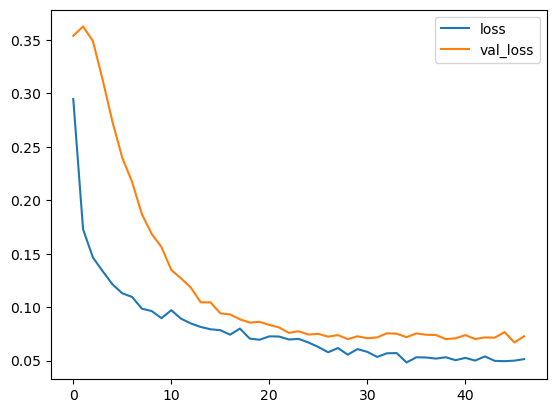

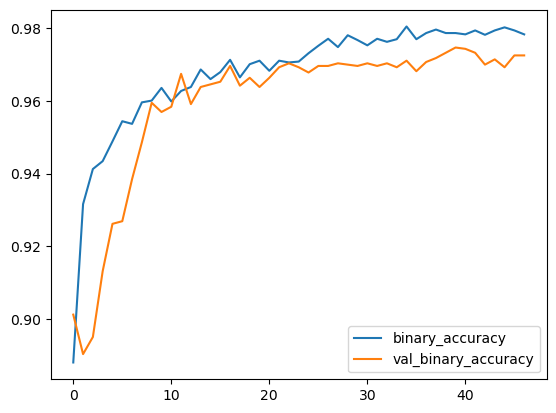

In [9]:
history_df = pd.DataFrame(history.history)
history_df.loc[0:, ['loss', 'val_loss']].plot()
history_df.loc[0:, ['binary_accuracy', 'val_binary_accuracy']].plot()

print(f"Best Validation Loss: {history_df['val_loss'].min()}" +\
      f"\nBest Validation Accuracy: {history_df['val_binary_accuracy'].max()}"+\
      f"\nBest Recall: {history_df['val_recall'].max()}" +\
      f"\nBest Precision: {history_df['val_precision'].max()}"
)

In [8]:
import joblib
import pickle

# Save the trained model
model_filename = 'DLphishing.pkl'
joblib.dump(model, model_filename)

# Save the history dataframe
history_filename = 'training_history.pkl'
with open(history_filename, 'wb') as file:
    pickle.dump(history_df, file)
